# DTSA 5511 Final Project
### Introduction

For my final project I have chosen to tackle an image classification problem presented by a Kaggle [dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset/data). The images in the dataset are of two different varieties of pistachios: "Siirt" and "Kirmizi", with the goal being to create a neural-network based model capable of reliably differentiating between them.

The general steps of the project will include exploring and pre-processing the data, preparing the model(s), training the models, and evaluating their performance.

All code for this project can be found on my GitHub: https://github.com/nhansendev/DTSA_5511_FinalProject

In [1]:
# Import required modules
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Bulky functions have been moved to separate files for brevity
from constants import SCRIPT_DIR, RANDOM_SEED
from utils import plot_img_tensor, sum_model_params, plot_features
from training import Trainer
from data_handling import DataHandler

### Exploratory Data Analysis
Images have been preprocessed into numpy arrays for faster loading compared to loading images one-at-a-time, though this method has high RAM requirements to keep the entire dataset in memory (see "preprocessing.py").

To aid model training the images are normalized after loading so that the color values are in the range -1 to 1, instead of 0 to 255:

In [2]:
# Read data from numpy files
siirt = np.load(os.path.join(SCRIPT_DIR, 'siirt.npy'))
kirmizi = np.load(os.path.join(SCRIPT_DIR, 'kirmizi.npy'))
print(siirt.shape)
print(kirmizi.shape)

(916, 600, 600, 3)
(1232, 600, 600, 3)


We can see that each image is 600x600 pixels, with three color channels (red, green, blue). There are 916 siirt images and 1232 kirmizi images, which will be independently sampled during training to ensure equal representation in each batch.

If we plot a few examples of each type of pistachio:

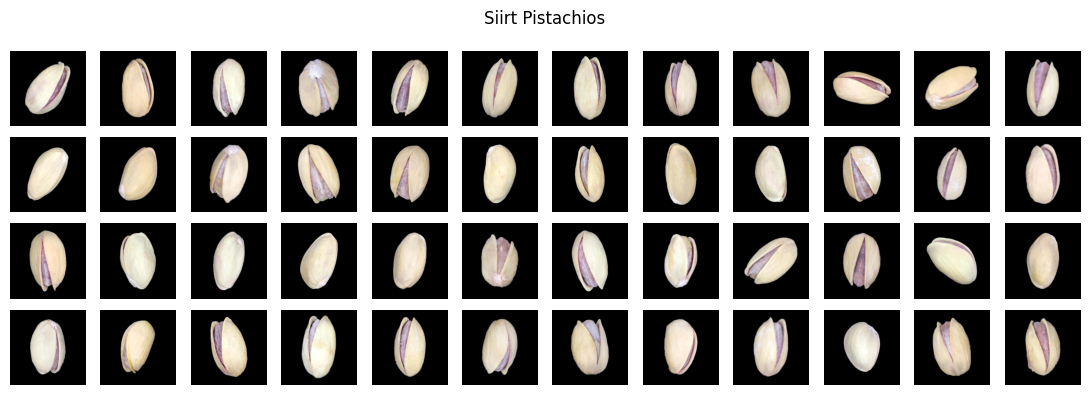

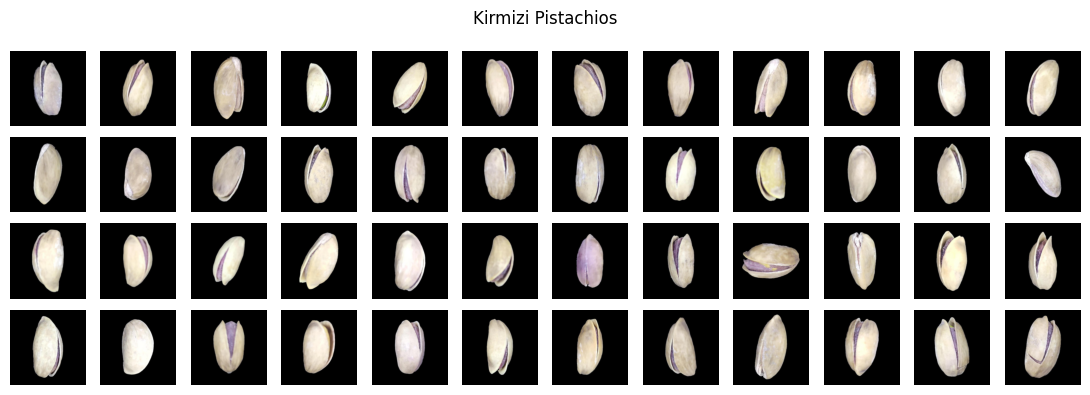

In [3]:
# Plot example images of each type
plot_img_tensor(siirt, "Siirt Pistachios", 4, 12, 11, 4)
plot_img_tensor(kirmizi, "Kirmizi Pistachios", 4, 12, 11, 4)

From the example images we can see that the differences between the two types are subtle, and that the images were taken at various orientations. 

By looking at the mean and standard deviation of the pixels across all images we can get an idea of where most variations occur:

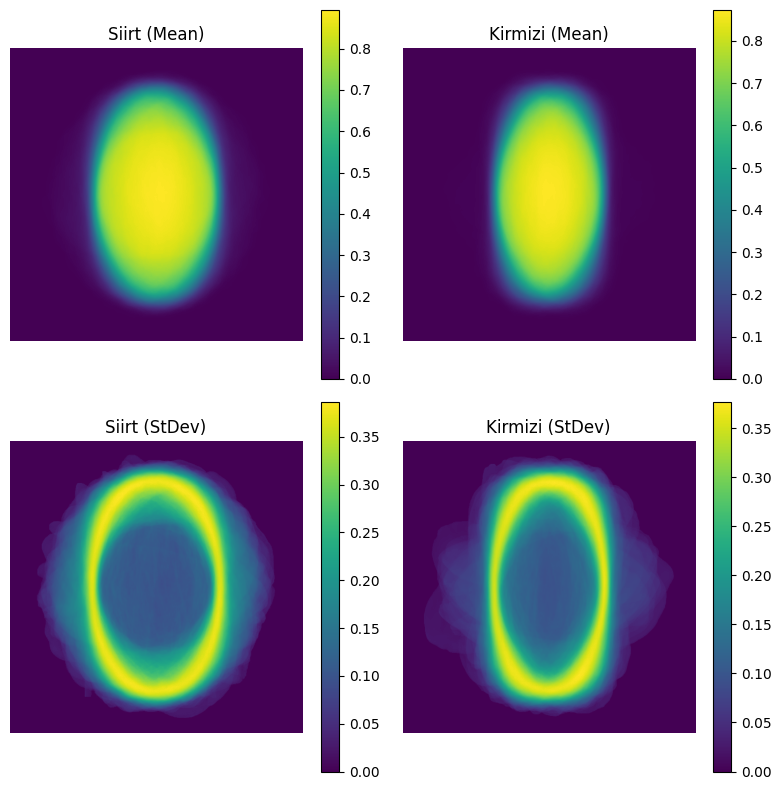

In [77]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

# Adjust data range to [0 to 1], then take mean of channel and batch axes
im = axs[0, 0].imshow(np.mean(siirt/255, axis=(3, 0)))
plt.colorbar(im)
im2 = axs[0, 1].imshow(np.mean(kirmizi/255, axis=(3, 0)))
plt.colorbar(im2)

# Adjust data range to [0 to 1], then take st.dev. of channel and batch axes
im = axs[1, 0].imshow(np.std(siirt/255, axis=(3, 0)))
plt.colorbar(im)
im2 = axs[1, 1].imshow(np.std(kirmizi/255, axis=(3, 0)))
plt.colorbar(im2)

axs[0, 0].set_title('Siirt (Mean)')
axs[0, 1].set_title('Kirmizi (Mean)')
axs[1, 0].set_title('Siirt (StDev)')
axs[1, 1].set_title('Kirmizi (StDev)')

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()

plt.show()

There are several observations that could be made from these plots:
1. Most images of the pistachios are with them oriented "upright" with their long axis aligned vertically
2. Images of the Siirt pistachios may appear in other orientations besides "upright" more frequently than Kirmizi
3. Siirt pistachios may be wider in general than Kirmizi, but with similar height (assuming a fixed camera distance)

Histograms of the average color values per channel are plotted below:

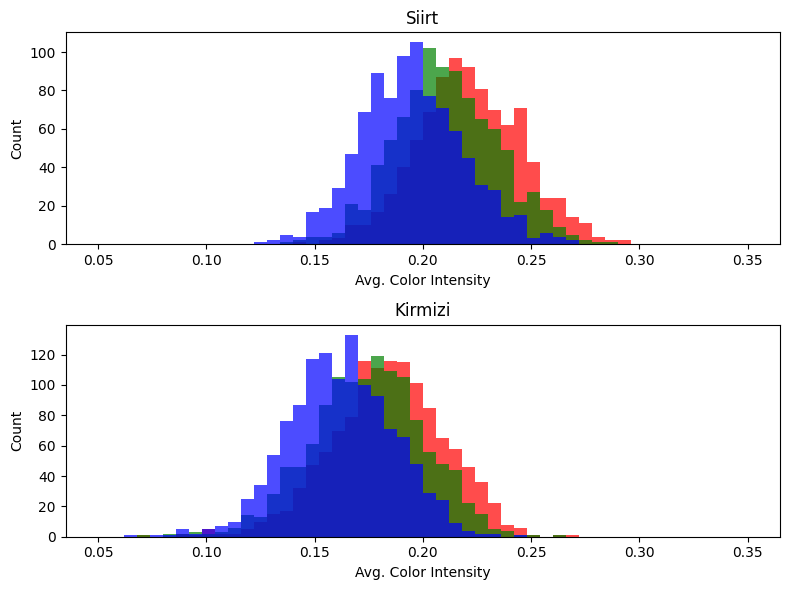

In [5]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(8, 6)
axs = fig.axes

# Adjust data range to [0 to 1], then take mean of channel and batch axes
tmp1 = np.mean(siirt/255, axis=(1, 2))
tmp2 = np.mean(kirmizi/255, axis=(1, 2))
bins = 50
for i in range(3):
    axs[0].hist(tmp1[:, i], bins=bins, range=(0.05, 0.35), histtype='bar', color='rgb'[i], alpha=0.7)
    axs[1].hist(tmp2[:, i], bins=bins, range=(0.05, 0.35), histtype='bar', color='rgb'[i], alpha=0.7)

axs[0].set_title('Siirt')
axs[1].set_title('Kirmizi')

for a in axs:
    a.set_xlabel('Avg. Color Intensity')
    a.set_ylabel('Count')

plt.tight_layout()

plt.show()

We can see that the distributions of colors for Siirt and Kirmizi are very similar, but shifted. This indicates that the average Kirmizi image is darker than the average Siirt image, which makes sense if Siirt pistachios are on average larger (or their picture are more "zoomed-in") so that less of the dark background is visible. Comparing the example images, it does make sense that their color distributions would be similar since their color patterns are subjectively very similar. 

### Data Augmentations
Data augmentations can be used to help the model adapt to the variations between images, including:
- Random Rotation
- Random Horizontal / Vertical Flip
- Random Resized Crop

The rotations and flips should help with the variable orientations in the images, while the resized crop will randomly "zoom-in" and shift the images before scaling them back to the starting size. This can help account for pistachios being shifted between images, variations in image quality, and size variations between pistachios. However, as noted in the data exploration the Siirt pistachios appear to be larger on average than the Kirmizi, suggesting that the resized crop may actually interfere with the model recognizing this difference. The augmentations will be applied in different combinations to evaluate this idea.

It may also be helpful to apply color-based augmentations, assuming that absolute color values are less important for identification than the color patterns within the images.
These augmentations will also be evaluated separately from the others to determine their effectiveness:
- Color Jitter (random brightness, contrast, saturation, and hue variation)

Prepare datasets and transformations:

In [3]:
# Split into training and validation sets
ratio = 0.9
RNG = np.random.default_rng(RANDOM_SEED)
train_idxs_s = torch.BoolTensor(
    RNG.choice(2, len(siirt), True, [1 - ratio, ratio])
)
train_idxs_k = torch.BoolTensor(
    RNG.choice(2, len(kirmizi), True, [1 - ratio, ratio])
)

# Create training data handler for performing augmentations
siirt_train = siirt[train_idxs_s]
kirmizi_train = kirmizi[train_idxs_k]

dataset = DataHandler(siirt_train, kirmizi_train)

# Create validation data set
siirt_test = torch.FloatTensor(siirt[~train_idxs_s]/127.5-1).permute(0, 3, 1, 2)
kirmizi_test = torch.FloatTensor(kirmizi[~train_idxs_k]/127.5-1).permute(0, 3, 1, 2)
valid_data = torch.cat((siirt_test, kirmizi_test)).cuda()
valid_labels = np.array([0]*len(siirt_test)+[1]*len(kirmizi_test))

print(siirt_train.shape, kirmizi_train.shape)
print(valid_data.shape, valid_labels.shape)

(837, 600, 600, 3) (1079, 600, 600, 3)
torch.Size([232, 3, 600, 600]) (232,)


Example augmentations:

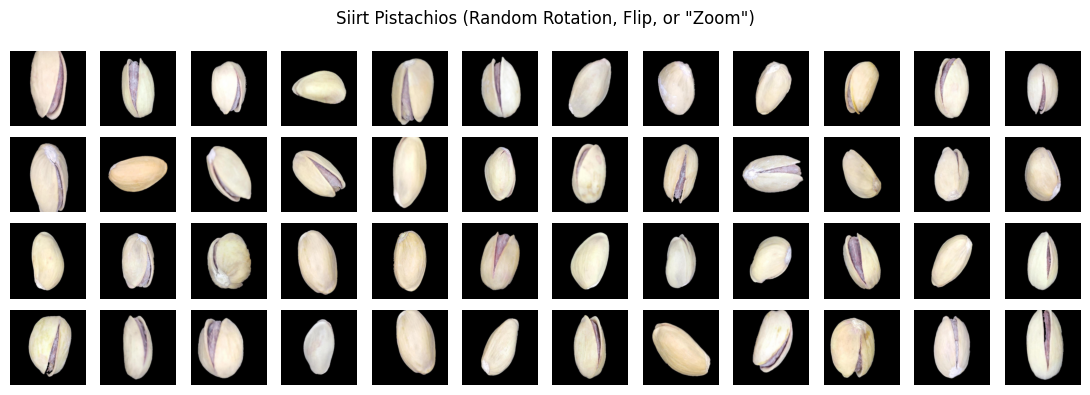

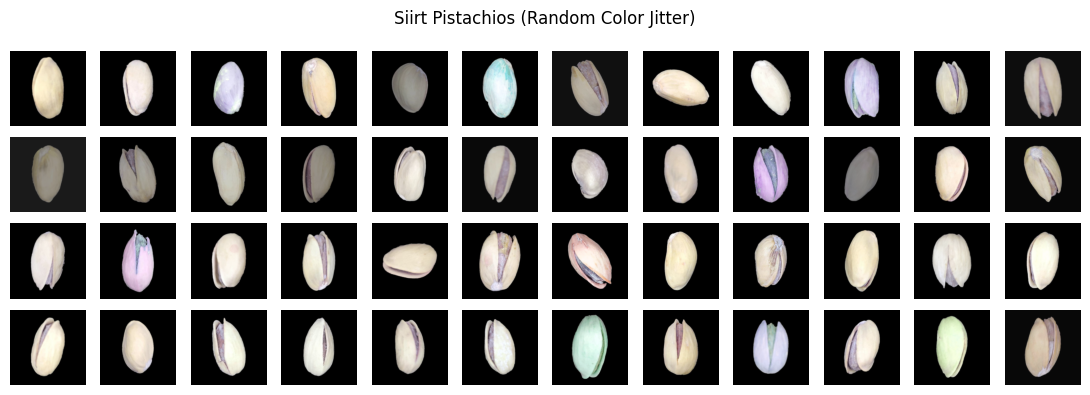

In [7]:
data = dataset.make_sample(48, True, True, True, False)
plot_img_tensor(data, 'Siirt Pistachios (Random Rotation, Flip, or "Zoom")', 4, 12, 11, 4)

data = dataset.make_sample(48, True, False, False, True)
plot_img_tensor(data, "Siirt Pistachios (Random Color Jitter)", 4, 12, 11, 4)

### Model Architecture
Based on the discriminator used in [CycleGAN](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/master), which was designed for image classification, the model topology is as follows:
1. A stack of down-sampling convolutional blocks encode the images into a more compact latent representation
2. Optional Residual Blocks, which increase the depth of the model to provide more capacity for complex feature extraction while mitigating the risk of exploding or vanishing gradients
3. Features are collapsed to a single channel (via convolution), followed by flattening and a Linear layer to adapt to the required category prediction (a scalar output)

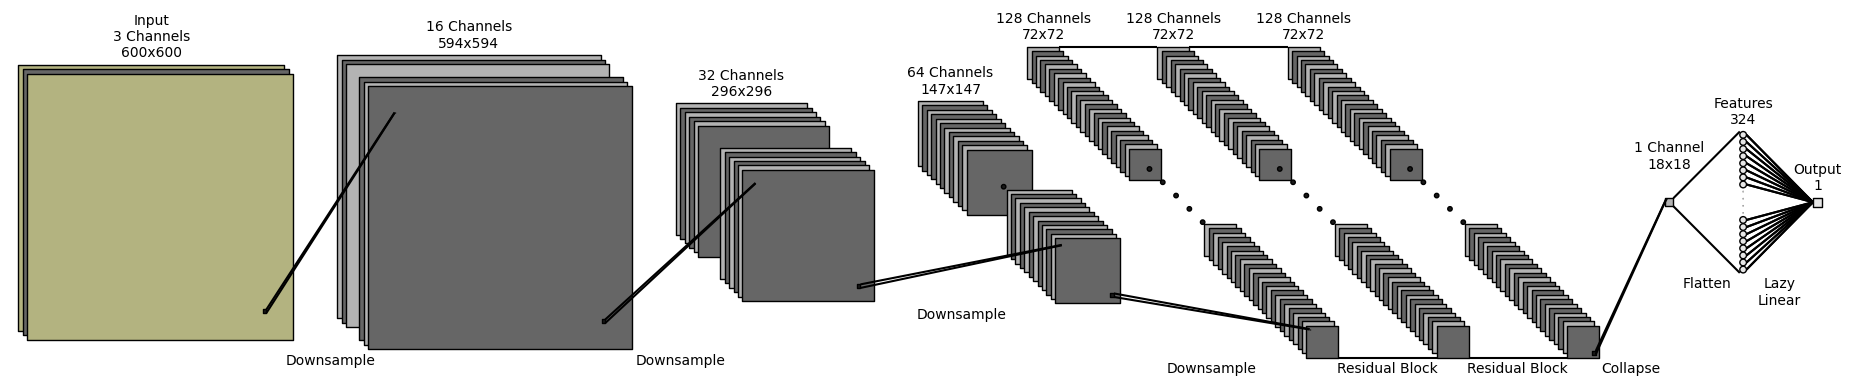

The downsampling convolutional blocks have the following structure:

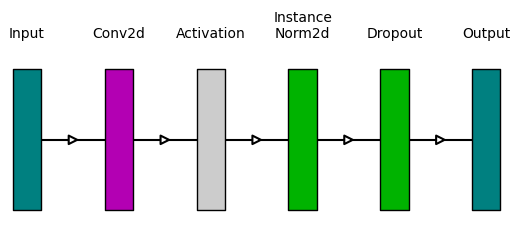

The residual blocks have the following structure:

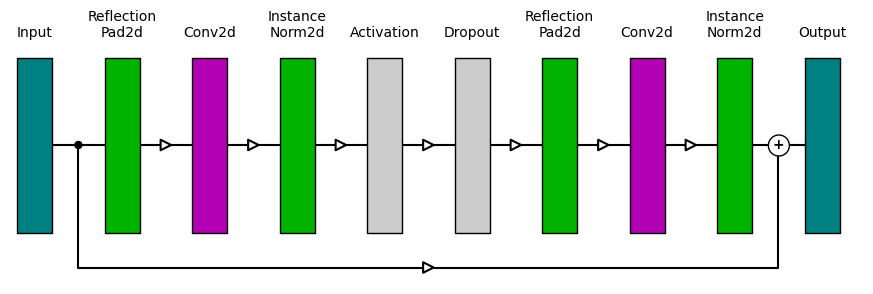


Images generated with: https://github.com/nhansendev/PyDrawNet

### Performance Metrics
During model training the [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) of the predicted and real classifications will be used as the loss function, which is applicable due to there being only two possible classification options (0 for Siirt, 1 for Kirmizi). The Mean Squared Error will also be tested as an alternate loss function.

The validation performance of the model will be evaluated using the [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). This will provide a better representation of model performance than "accuracy", since it requires that both the false-positive and false-negative rates are low to achieve a good score.

### Hyperparameter Variations

Several variations of model hyperparameters and data augmentations will be evaluated to determine the effect of each on model performance:
1. Varying the size of the model through the number of convolution blocks and residual blocks
2. Varying the size of the kernel used in the convolutions
3. Adding dropout for additional regularization
4. The three groups of augmentation types
5. Applying the same augmentation across a batch of images, or a random augmentation to each image in the batch
6. Instance normalization vs Batch normalization
7. BCE loss vs MSE loss

In [4]:
columns = ['Use Geo Aug', 'Use Crop Aug', 'Use Color Aug', 'Batched Aug', 'Norm Type', 'Model Size', 'Kernel Size', 'Model Depth', 'Model Layers', "Dropout", "Loss FN", 'Parameters', 'Train Loss', 'Valid F1 Score']
default_values = [False, False, False, True, 'Instance', 'L', 2, 5, 5, 0, "BCE", 'TBD', 'TBD', 'TBD']

runs_dict = {columns[i]: [] for i in range(len(columns))}

def insert_row(dct, to_table=False):
    if to_table:
        tmp = {columns[i]: default_values[i] for i in range(len(columns))}
        for k, v in dct.items():
            tmp[k] = v
        runs_table.loc[-1] = tmp
        runs_table.index += 1
        runs_table.sort_index(inplace=True)
    else:
        for i, c in enumerate(columns):
            if c in dct.keys():
                runs_dict[c].append(dct[c])
            else:
                runs_dict[c].append(default_values[i])

insert_row({'Loss FN': 'MSE'})
insert_row({'Model Size': "S", "Model Depth": 3, 'Model Layers': 0}) 
insert_row({'Model Size': "M", "Model Depth": 4, 'Model Layers': 3}) 
insert_row({'Model Size': "L", "Model Depth": 5, 'Model Layers': 5}) 
insert_row({'Kernel Size': 4})
insert_row({'Kernel Size': 6})
insert_row({'Dropout': 0.5})
insert_row({'Use Geo Aug': True})
insert_row({'Use Crop Aug': True})
insert_row({'Use Color Aug': True})
insert_row({'Use Geo Aug': True, "Batched Aug": False})
insert_row({'Norm Type': 'Batch'})

runs_table = pd.DataFrame(runs_dict)
runs_table

Use Geo Aug  Use Crop Aug  Use Color Aug  Batched Aug Norm Type  \
0         False         False          False         True  Instance   
1         False         False          False         True  Instance   
2         False         False          False         True  Instance   
3         False         False          False         True  Instance   
4         False         False          False         True  Instance   
5         False         False          False         True  Instance   
6         False         False          False         True  Instance   
7          True         False          False         True  Instance   
8         False          True          False         True  Instance   
9         False         False           True         True  Instance   
10         True         False          False        False  Instance   
11        False         False          False         True     Batch   

   Model Size  Kernel Size  Model Depth  Model Layers  Dropout Loss FN  \
0           L            2            5             5      0.0     MSE   
1           S            2            3             0      0.0     BCE   
2           M            2            4             3      0.0     BCE   
3           L            2            5             5      0.0     BCE   
4           L            4            5             5      0.0     BCE   
5           L            6            5             5      0.0     BCE   
6           L            2            5             5      0.5     BCE   
7           L            2            5             5      0.0     BCE   
8           L            2            5             5      0.0     BCE   
9           L            2            5             5      0.0     BCE   
10          L            2            5             5      0.0     BCE   
11          L            2            5             5      0.0     BCE   

   Parameters Train Loss Valid F1 Score  
0         TBD        TBD            TBD  
1         TBD        TBD            TBD  
2         TBD        TBD            TBD  
3         TBD        TBD            TBD  
4         TBD        TBD            TBD  
5         TBD        TBD            TBD  
6         TBD        TBD            TBD  
7         TBD        TBD            TBD  
8         TBD        TBD            TBD  
9         TBD        TBD            TBD  
10        TBD        TBD            TBD  
11        TBD        TBD            TBD

Model sizes are determined by the number of parameters, which are limited for Large models by available GPU RAM.

In [78]:
# Example of model architecture:
Trainer(dataset, valid_data, valid_labels, depth=3, res_layers=1, show_summary=True);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─CNNLayer: 2-1                     [-1, 16, 594, 594]        2,368
|    └─CNNLayer: 2-2                     [-1, 32, 296, 296]        8,224
|    └─CNNLayer: 2-3                     [-1, 64, 147, 147]        32,832
|    └─CNNLayer: 2-4                     [-1, 128, 72, 72]         131,200
|    └─ResidualBlock: 2-5                [-1, 128, 72, 72]         524,544
|    └─CNNLayer: 2-6                     [-1, 1, 18, 18]           2,049
|    └─Flatten: 2-7                      [-1, 324]                 --
|    └─Linear: 2-8                       [-1, 1]                   325
Total params: 701,542
Trainable params: 701,542
Non-trainable params: 0
Total mult-adds (M): 2.10
Input size (MB): 4.12
Forward/backward pass size (MB): 0.00
Params size (MB): 2.68
Estimated Total Size (MB): 6.80


#### Running Iterations

In [7]:
def run(index, row):
    # Cleanup previous run
    try:
        del TR
    except NameError:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    
    # For reproducibility
    torch.manual_seed(RANDOM_SEED);
    torch.cuda.manual_seed(RANDOM_SEED);

    print(f'Index: {index}')

    dataset.reset() # For consistency between runs

    # Set augmentation config
    dataset.use_geo_aug = row['Use Geo Aug']
    dataset.use_crop_aug = row['Use Crop Aug']
    dataset.use_color_aug = row['Use Color Aug']
    dataset.batch_size = 4
    dataset.batch_aug = row['Batched Aug']

    # Create trainer with appropriate configuration
    TR = Trainer(dataset, 
                 valid_data, 
                 valid_labels, 
                 depth=row["Model Depth"], 
                 res_layers=row['Model Layers'], 
                 dropout=row['Dropout'], 
                 inst_norm=row['Norm Type']=='Instance', 
                 bce_loss=row['Loss FN']=='BCE',
                 show_summary=False,
                 )
    
    runs_table.loc[index, 'Parameters'] = sum_model_params(TR.classifier)
    
    # Run training
    TR.train(6000)

    # Update table
    runs_table.loc[index, 'Train Loss'] = np.round(TR.loss_hist[-1], 3)
    runs_table.loc[index, 'Valid F1 Score'] = np.round(TR.best_score, 3)
    TR.plot_hist(title=f'Index: {index}', width=16, height=5, show_CM=True)

    return TR

Index: 0


100%|██████████| 6000/6000 [05:44<00:00, 17.40it/s]


Final Loss: 6.01e-03


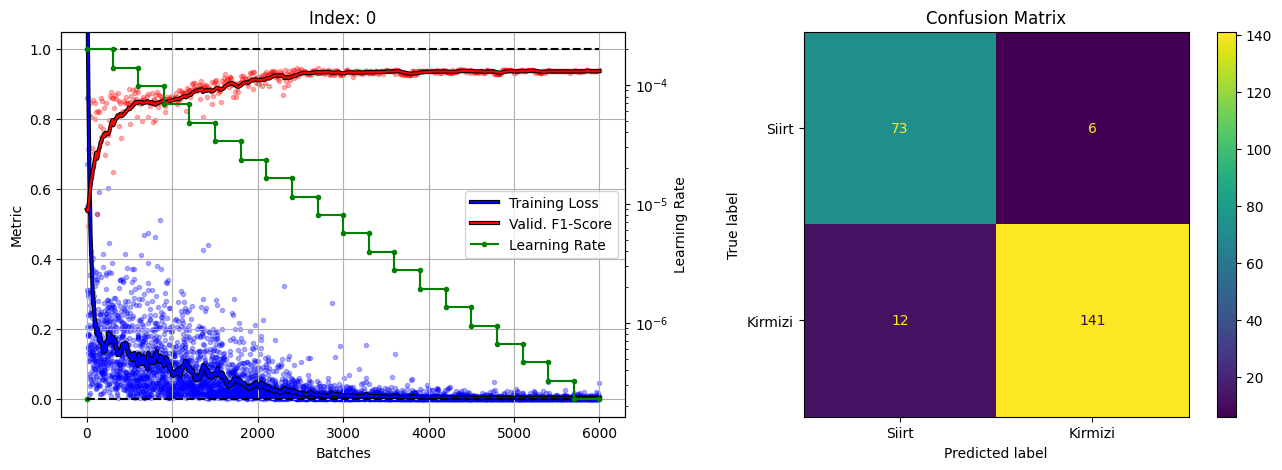

Index: 1


100%|██████████| 6000/6000 [02:24<00:00, 41.49it/s]


Final Loss: 2.28e-01


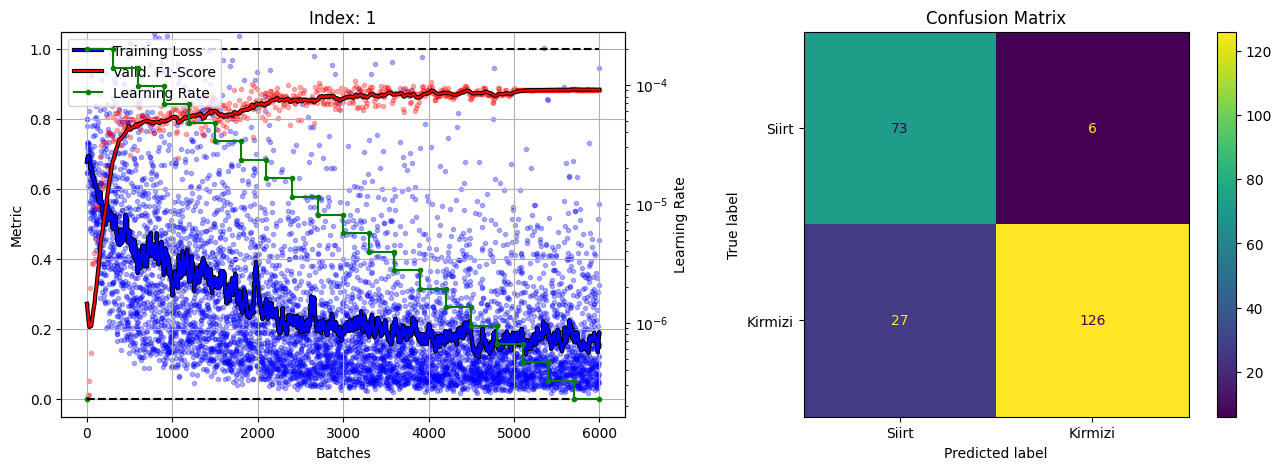

Index: 2


100%|██████████| 6000/6000 [04:14<00:00, 23.58it/s]


Final Loss: 7.72e-02


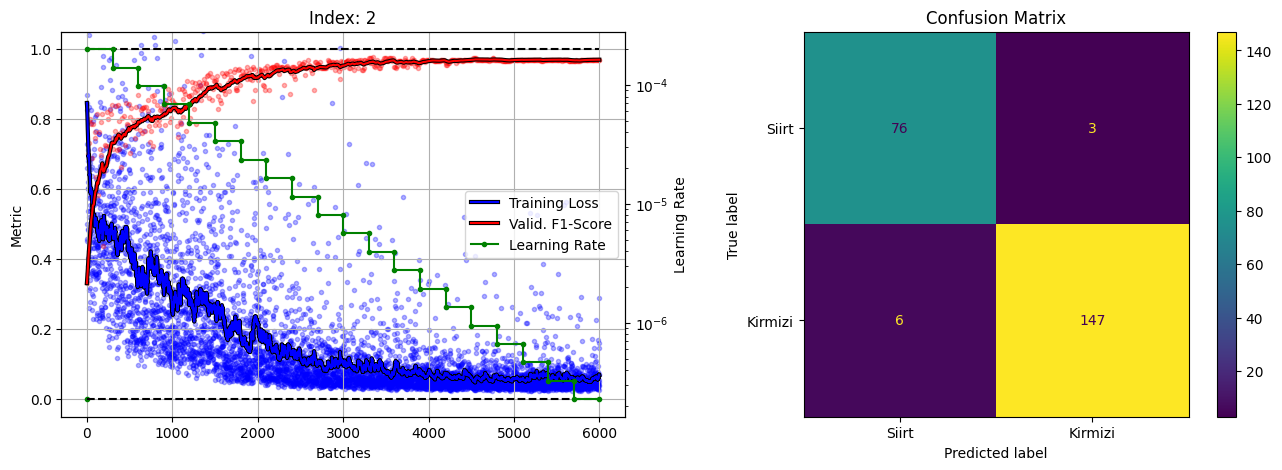

Index: 3


100%|██████████| 6000/6000 [05:32<00:00, 18.05it/s]


Final Loss: 1.14e-01


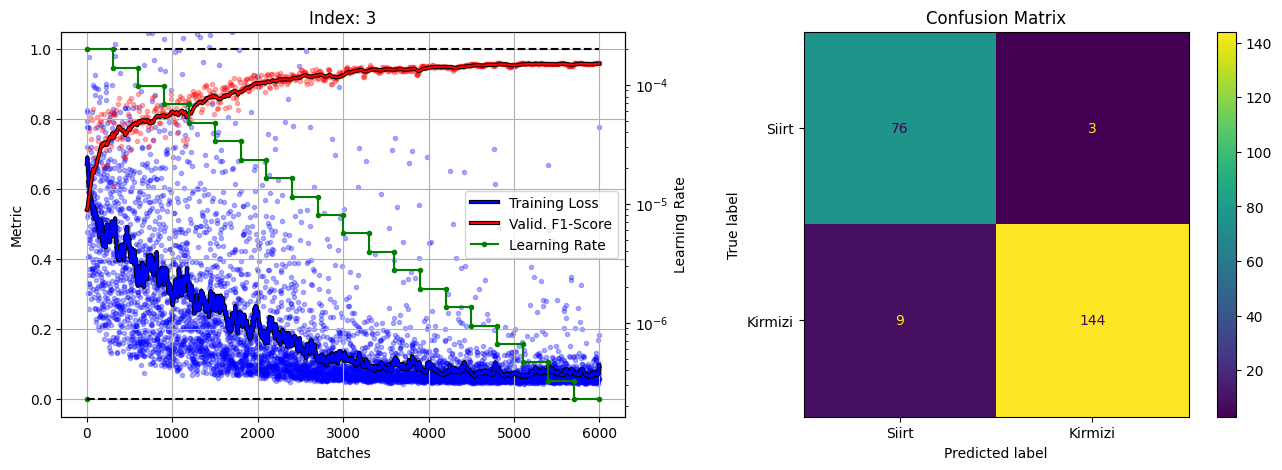

Index: 4


100%|██████████| 6000/6000 [05:26<00:00, 18.36it/s]


Final Loss: 1.07e-01


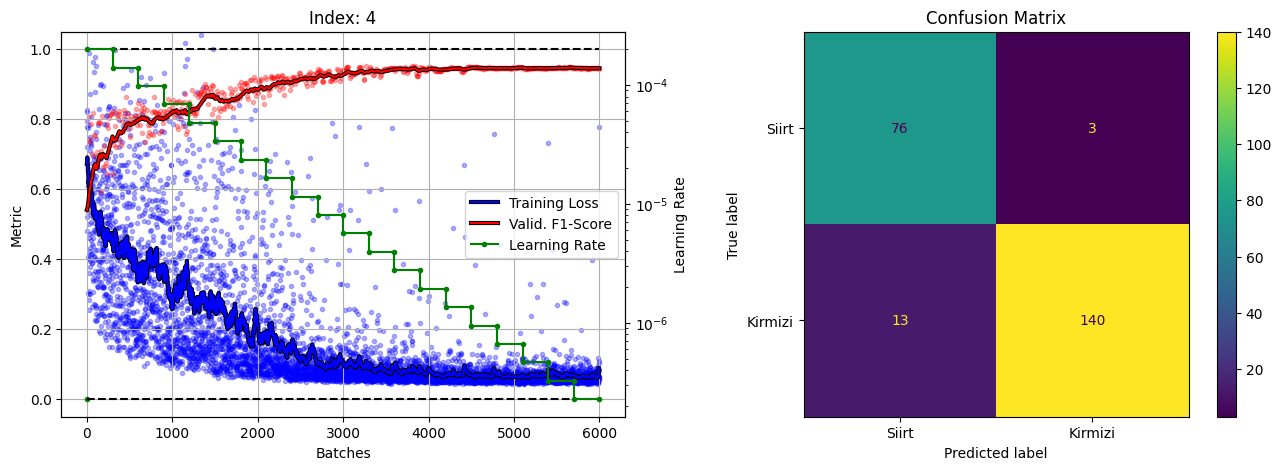

Index: 5


100%|██████████| 6000/6000 [05:22<00:00, 18.63it/s]


Final Loss: 1.04e-01


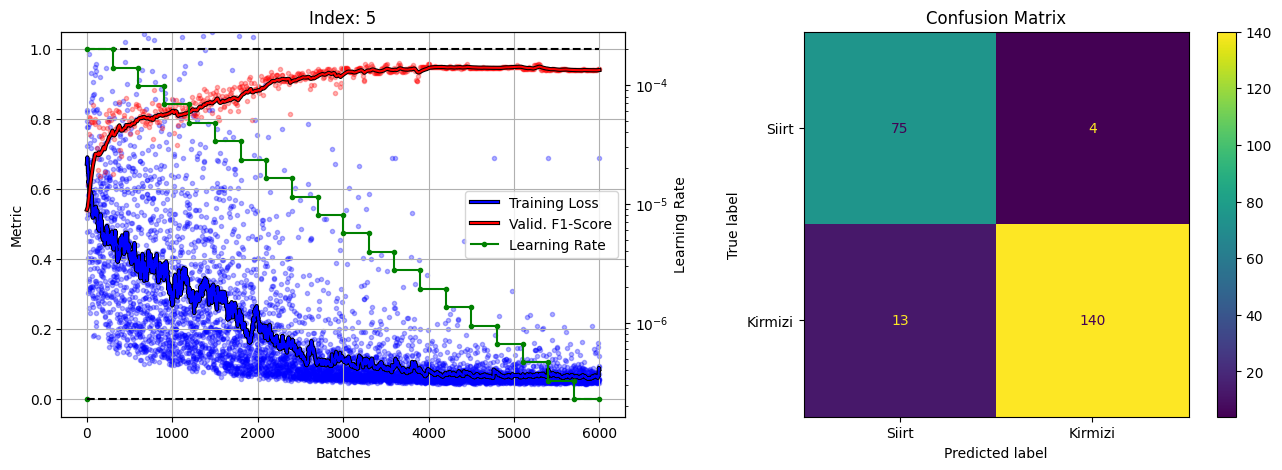

Index: 6


100%|██████████| 6000/6000 [05:21<00:00, 18.65it/s]


Final Loss: 3.68e-01


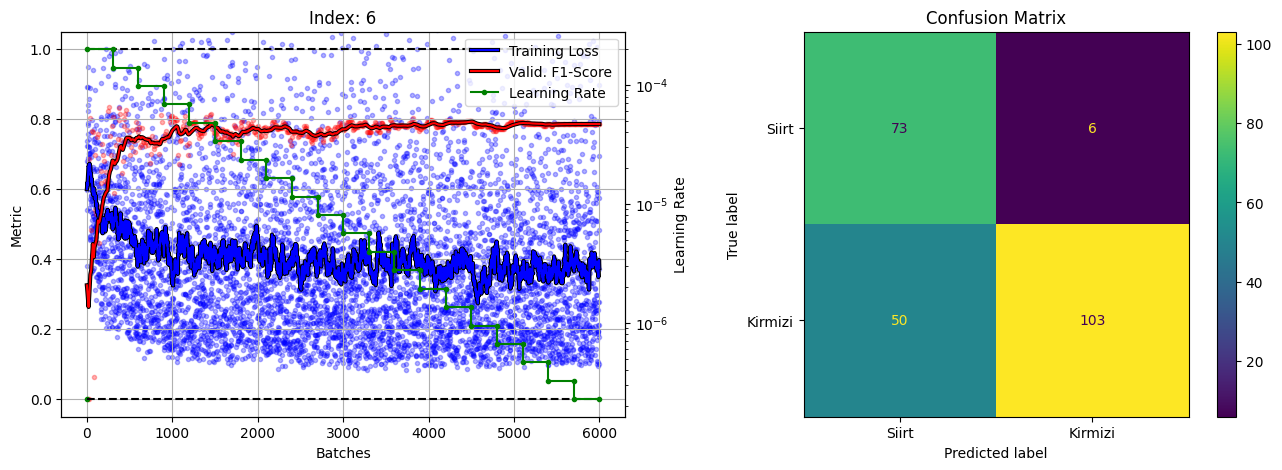

Index: 7


100%|██████████| 6000/6000 [05:25<00:00, 18.42it/s]


Final Loss: 1.95e-01


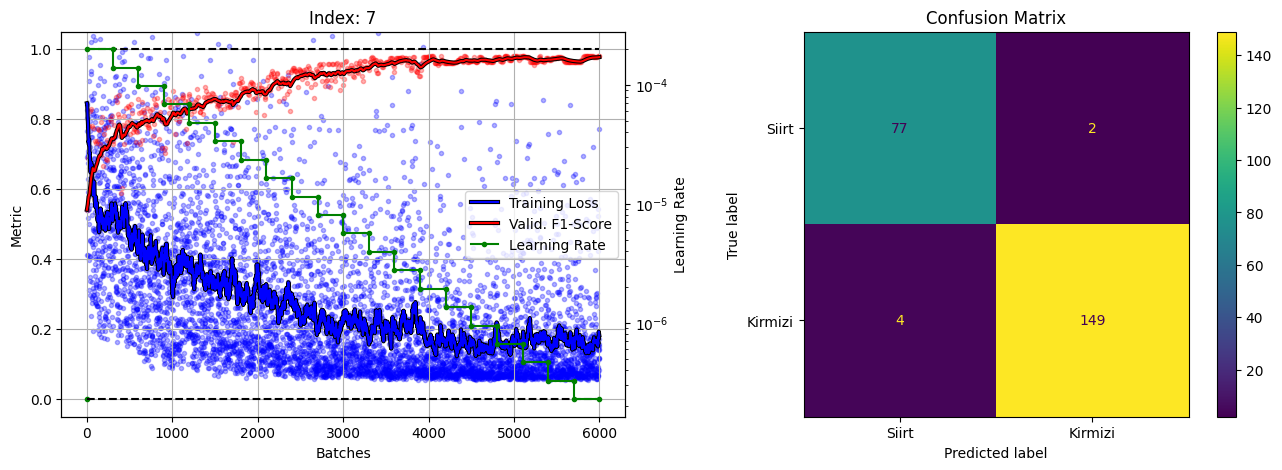

Index: 8


100%|██████████| 6000/6000 [05:22<00:00, 18.59it/s]


Final Loss: 2.18e-01


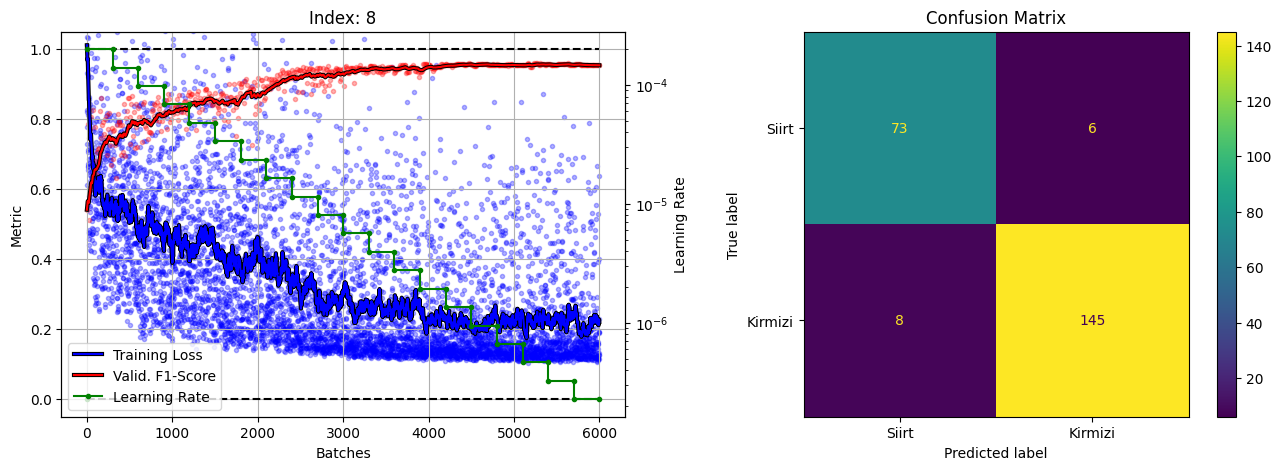

Index: 9


100%|██████████| 6000/6000 [05:26<00:00, 18.36it/s]


Final Loss: 1.76e-01


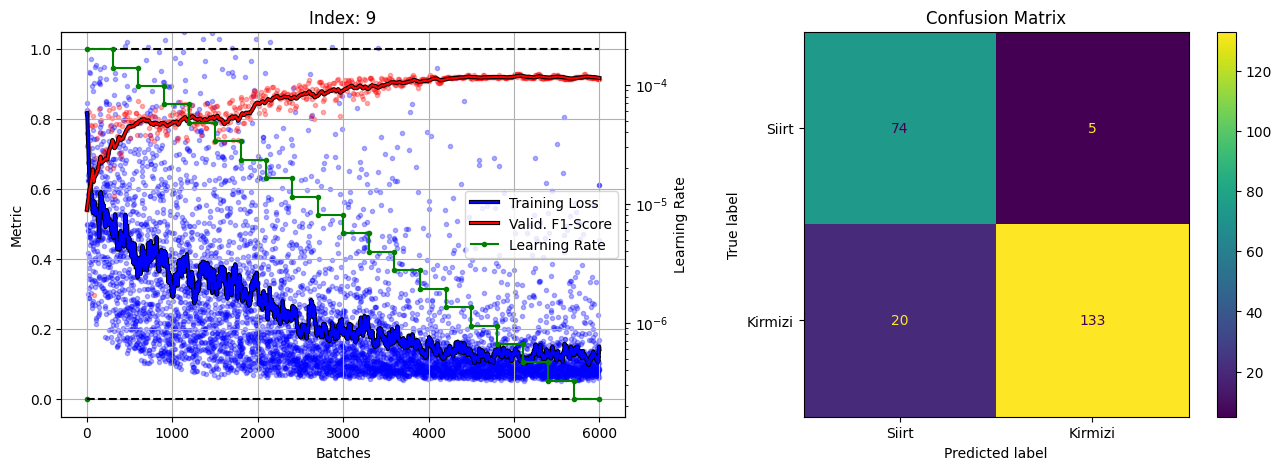

Index: 10


100%|██████████| 6000/6000 [05:33<00:00, 17.99it/s]


Final Loss: 2.35e-01


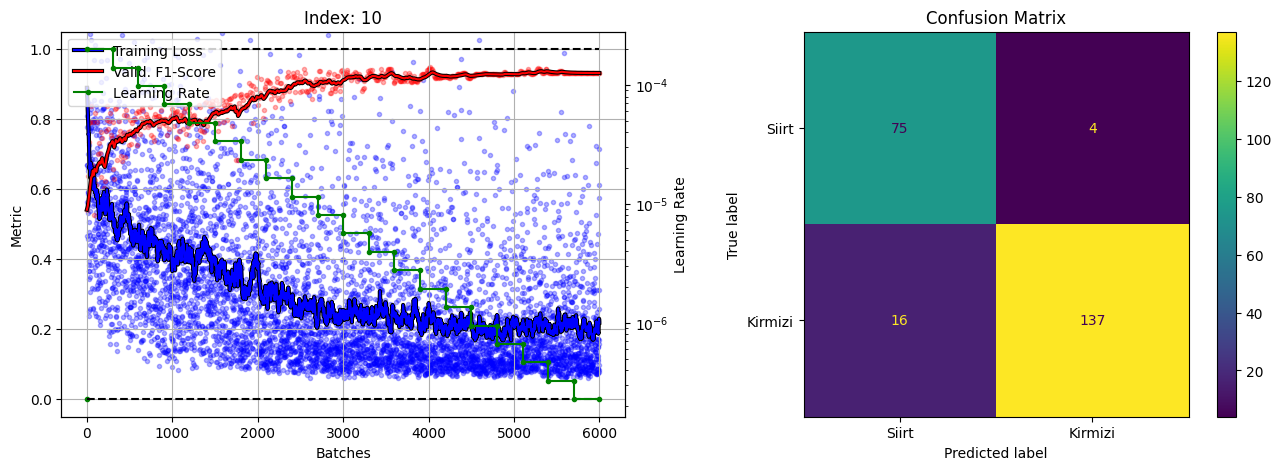

Index: 11


100%|██████████| 6000/6000 [06:27<00:00, 15.49it/s]


Final Loss: 6.93e-02


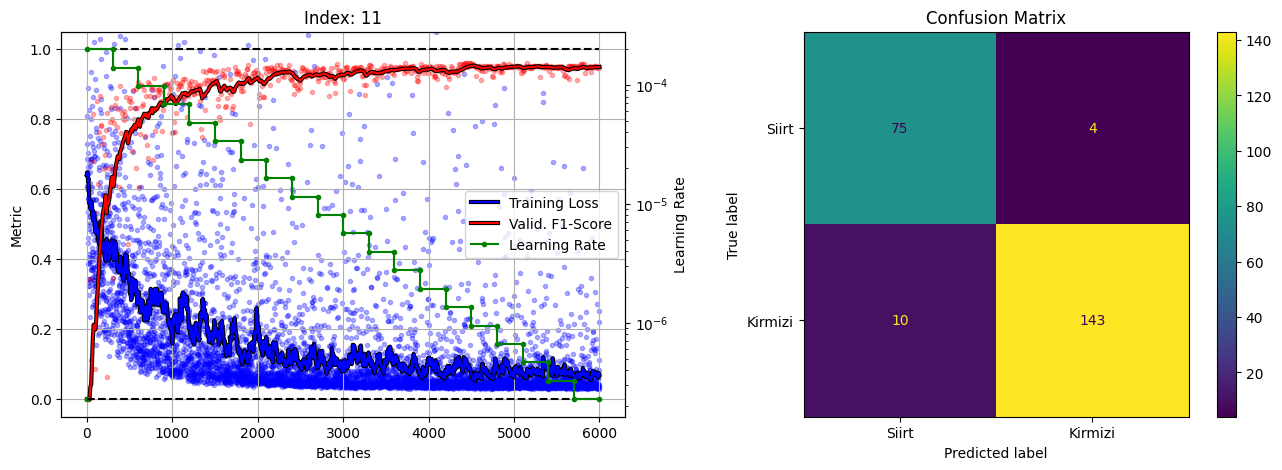

In [10]:
best_index = 0
best_score = 0

# Run each iteration (row) in the table
for index, row in runs_table.iterrows():
    TR = run(index, row)

    # Track the best-performing model
    if TR.best_score > best_score:
        best_score = TR.best_score
        best_index = index
        # Save best model params
        TR.save_model(True)

### Results

In [82]:
print(f'Best Index: {best_index}')
runs_table['Relative Score'] = runs_table['Valid F1 Score'] - runs_table.loc[3, 'Valid F1 Score']
runs_table

Best Index: 7


Use Geo Aug  Use Crop Aug  Use Color Aug  Batched Aug Norm Type  \
0         False         False          False         True  Instance   
1         False         False          False         True  Instance   
2         False         False          False         True  Instance   
3         False         False          False         True  Instance   
4         False         False          False         True  Instance   
5         False         False          False         True  Instance   
6         False         False          False         True  Instance   
7          True         False          False         True  Instance   
8         False          True          False         True  Instance   
9         False         False           True         True  Instance   
10         True         False          False        False  Instance   
11        False         False          False         True     Batch   

   Model Size  Kernel Size  Model Depth  Model Layers  Dropout Loss FN  \
0           L            2            5             5      0.0     MSE   
1           S            2            3             0      0.0     BCE   
2           M            2            4             3      0.0     BCE   
3           L            2            5             5      0.0     BCE   
4           L            4            5             5      0.0     BCE   
5           L            6            5             5      0.0     BCE   
6           L            2            5             5      0.5     BCE   
7           L            2            5             5      0.0     BCE   
8           L            2            5             5      0.0     BCE   
9           L            2            5             5      0.0     BCE   
10          L            2            5             5      0.0     BCE   
11          L            2            5             5      0.0     BCE   

   Parameters Train Loss Valid F1 Score Relative Score  
0    44753185      0.001          0.947         -0.013  
1      176673      0.046          0.908         -0.052  
2     6996257      0.037          0.977          0.017  
3    44753185      0.062           0.96            0.0  
4    44753185      0.055          0.953         -0.007  
5    44753185      0.057          0.961          0.001  
6    44753185      0.102          0.836         -0.124  
7    44753185      0.141           0.98           0.02  
8    44753185      0.115           0.96            0.0  
9    44753185      0.064          0.929         -0.031  
10   44753185      0.079           0.95          -0.01  
11   44765411      0.037          0.967          0.007

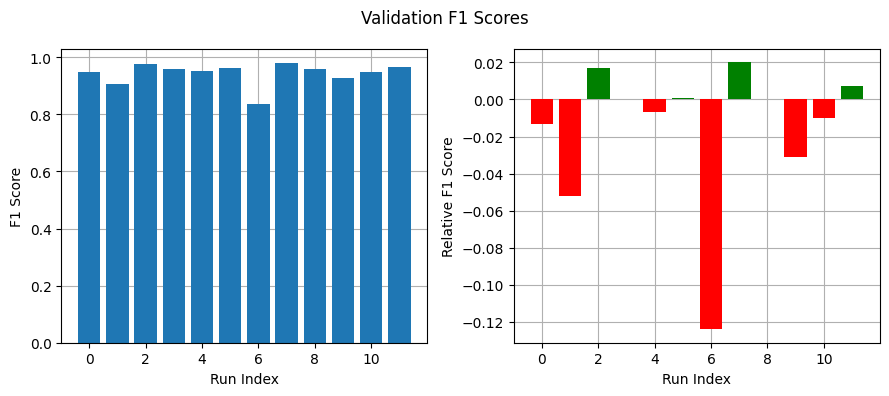

In [83]:
fig, ax = plt.subplots(1, 2)
axs = fig.axes
fig.set_size_inches(9, 4)

axs[0].bar(runs_table.index, runs_table['Valid F1 Score'])
axs[1].bar(runs_table.index, runs_table['Relative Score'], color=['rg'[int(v)] for v in runs_table['Relative Score']>0])
axs[0].set_xlabel('Run Index')
axs[1].set_xlabel('Run Index')
axs[0].set_ylabel('F1 Score')
axs[1].set_ylabel('Relative F1 Score')
plt.suptitle('Validation F1 Scores')
axs[0].grid()
axs[1].grid()
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)

plt.tight_layout()
plt.show()

It's important to note that while consistency can be maintained between runs through re-seeding all random number generators and using [deterministic](https://pytorch.org/docs/stable/notes/randomness.html) network layers, result may change as the random seed changes.

From the results table and scores plot we can make the following observations:
- Most hyperparameter adjustments did not have a large effect (<+/-2%) on the performance of the baseline (Large mode, #3)
- The best performing model was #7, the Large model with geometric augmentations (rotation and flip), with a F1-score of 0.98
- The baseline Medium model (#2) performed nearly as well with an F1-score of 0.977, suggesting that the Large model is over fitting
- Adding dropout (#6) was very detrimental to model performance, which is surprising since it can be used to reduce the tendency of large models to over-fit
    - It's possible that dropout was simply added to too many layers in the model, or was set to too high of a value
- The use of MSE loss instead of BCE loss (#0) had only a small negative impact on F1-score
    - Looking at the training plots and final losses we can see that the MSE loss is able to approach zero while eliminating most of the "noise" visible on other plots
    - This might indicate that the tendency of MSE to focus on outlier values is detrimental to overall performance
    - The small gradients as the loss function rapidly approaches zero may also inhibit training
- Varying the kernel size had little to no effect (#4, #5)
    - If the Large models are already over-fitting, then the difference in kernel sizes might be more significant with smaller models
- The "zoom" (rescale and crop) and color augmentations were neutral, or detrimental to performance (#8, #9)
    - As noted earlier, these augmentations may "hide" useful information
- Applying separate augmentations (geo. augmentations) to each image in a batch instead of using the same augmentation across the batch had a relatively large negative effect (#10 @ 0.95, compared to #7 @ 0.98)
    - This might generate less clear, or consistent signals for the optimizer to follow as it tries to adapt to multiple variations at once

### Exploring the Model

Looking at the samples that the best model had the most and least difficulty identifying may tell us more about how it works:

In [6]:
# Load best saved model
try:
    del TR
except NameError:
    pass
torch.cuda.empty_cache()
gc.collect()

row = runs_table.loc[best_index]
dataset.reset() # For consistency between runs
dataset.use_geo_aug = row['Use Geo Aug']
dataset.use_crop_aug = row['Use Crop Aug']
dataset.use_color_aug = row['Use Color Aug']
dataset.batch_size = 4
dataset.batch_aug = row['Batched Aug']
TR = Trainer(dataset, 
                valid_data, 
                valid_labels, 
                depth=row["Model Depth"], 
                res_layers=row['Model Layers'], 
                dropout=row['Dropout'], 
                inst_norm=row['Norm Type']=='Instance', 
                bce_loss=row['Loss FN']=='BCE',
                show_summary=False,
                )
TR.load_model()

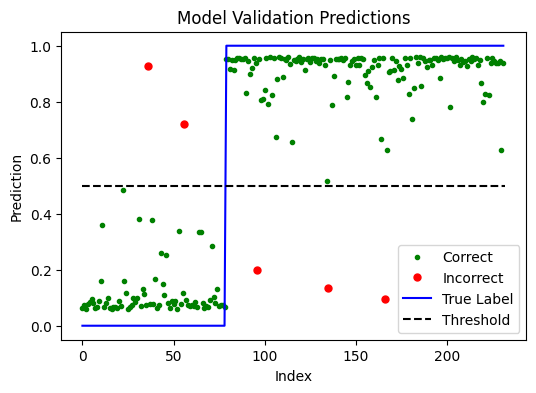

In [38]:
# Plot predictions
with torch.no_grad():
    TR.classifier.eval()
    with torch.autocast(device_type="cuda"):
        pred = torch.nn.functional.sigmoid(TR.classifier(valid_data))

pred = pred.cpu().flatten().numpy()
err = np.abs(pred-valid_labels).tolist()

err_idxs = np.abs((pred>0.5).astype(int) - valid_labels)>0
plt.plot(pred, 'g.')
plt.plot(np.arange(len(pred))[err_idxs], pred[err_idxs], 'r.', markersize=10)
plt.plot(valid_labels, 'b-')
plt.gcf().set_size_inches(6, 4)
plt.title('Model Validation Predictions')
plt.hlines(0.5, 0, len(pred), 'k', 'dashed')
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.legend(['Correct', 'Incorrect', 'True Label', 'Threshold'])
plt.show()

The model outputs a value between 0 and 1, with 0.5 used as the threshold for its predicted classification (0 for Siirt, 1 for Kirmizi). If we assume that the model's "confidence" is represented by how far each prediction is from the threshold, then we can identify which samples were the easist or hardest to predict (values were scaled from [0 to 0.5] to [0 to 1] range to be more intuitive):

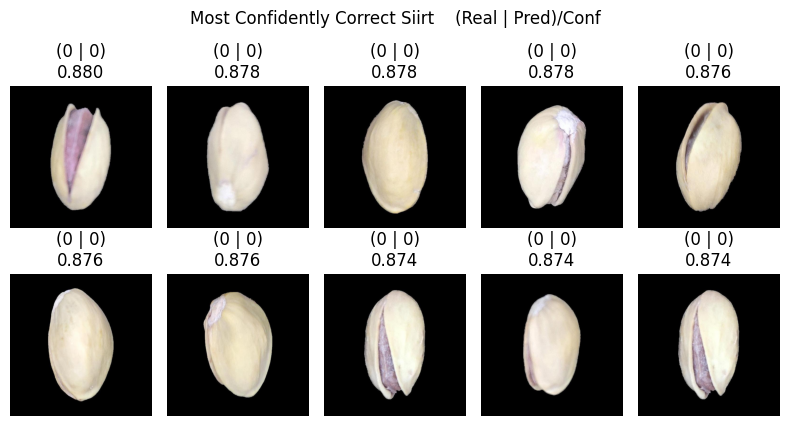

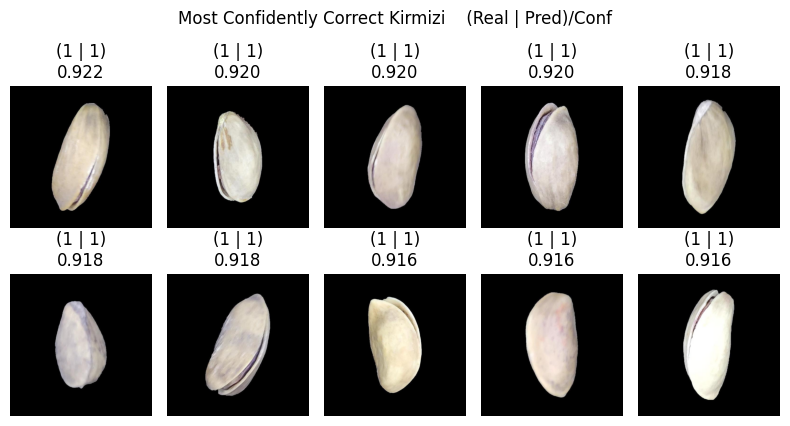

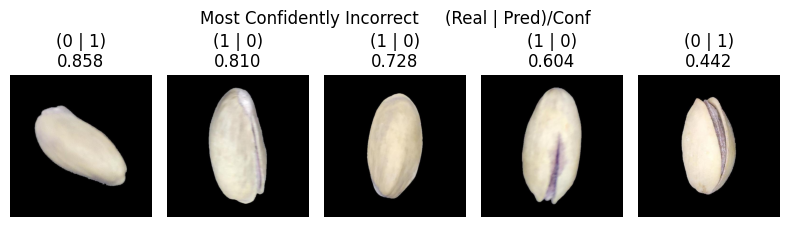

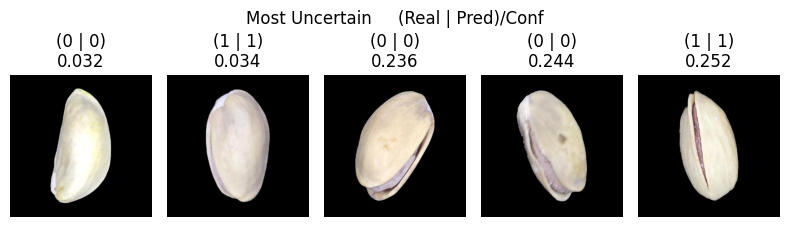

In [48]:
# Identify easiest and hardest to predict validation samples
pairs = [[round(e, 3), valid_labels[i], valid_data[i], pred[i]] for i, e in enumerate(err)]
pairs.sort(key=lambda x: x[0])
sorted_errs, sorted_labels, sorted_data, sorted_preds = list(zip(*pairs))

wrong_count = sum(np.abs((pred>0.5) - valid_labels))

N = 10
# Most Confidently Correct Siirt (Lowest Error)
indexes = []
for i in range(len(err)):
    if sorted_labels[i] == 0:
        indexes.append(i)
    if len(indexes) >= N:
        break
labels = [f"({sorted_labels[i]} | {int(sorted_preds[i]>0.5)})\n{2*abs(sorted_errs[i]-0.5):.3f}" for i in indexes]
plot_img_tensor(torch.stack([sorted_data[i] for i in indexes]), labels=labels, r=N//5, c=5, w=8, h=2*N//5+0.5, title='Most Confidently Correct Siirt    (Real | Pred)/Conf')

N = 10
# Most Confidently Correct Kirmizi (Lowest Error)
indexes = []
for i in range(len(err)):
    if sorted_labels[i] == 1:
        indexes.append(i)
    if len(indexes) >= N:
        break
labels = [f"({sorted_labels[i]} | {int(sorted_preds[i]>0.5)})\n{2*abs(sorted_errs[i]-0.5):.3f}" for i in indexes]
plot_img_tensor(torch.stack([sorted_data[i] for i in indexes]), labels=labels, r=N//5, c=5, w=8, h=2*N//5+0.5, title='Most Confidently Correct Kirmizi    (Real | Pred)/Conf')

N = min(15, wrong_count)
# Most Confidently Wrong (Highest Error)
labels = [f"({sorted_labels[-i]} | {int(sorted_preds[-i]>0.5)})\n{2*abs(sorted_errs[-i]-0.5):.3f}" for i in range(1, N+1)]
r = int(np.ceil(wrong_count/5))
h = 2*r+0.5
plot_img_tensor(torch.stack(sorted_data[-N:]), labels=labels, r=r, c=5, w=8, h=h, title='Most Confidently Incorrect     (Real | Pred)/Conf')

N = 5
# Most Uncertain
labels = [f"({sorted_labels[-wrong_count-i]} | {int(sorted_preds[-wrong_count-i]>0.5)})\n{2*abs(sorted_errs[-wrong_count-i]-0.5):.3f}" for i in range(1, N+1)]
plot_img_tensor(torch.stack(sorted_data[-wrong_count-N:-N]), labels=labels, r=1, c=5, w=8, h=2.5, title='Most Uncertain     (Real | Pred)/Conf')

Looking at the example images our earlier intuition seems to be correct: a key characteristic of the species is that the typical Siirt may be rounder or wider than the typical Kirmizi. This is also reflected in the confidently incorrect and uncertain examples.

We can observe some of the features the model uses to identify each species by plotting the intermediate outputs of the model (one image represents one channel, and one row represents one layer):

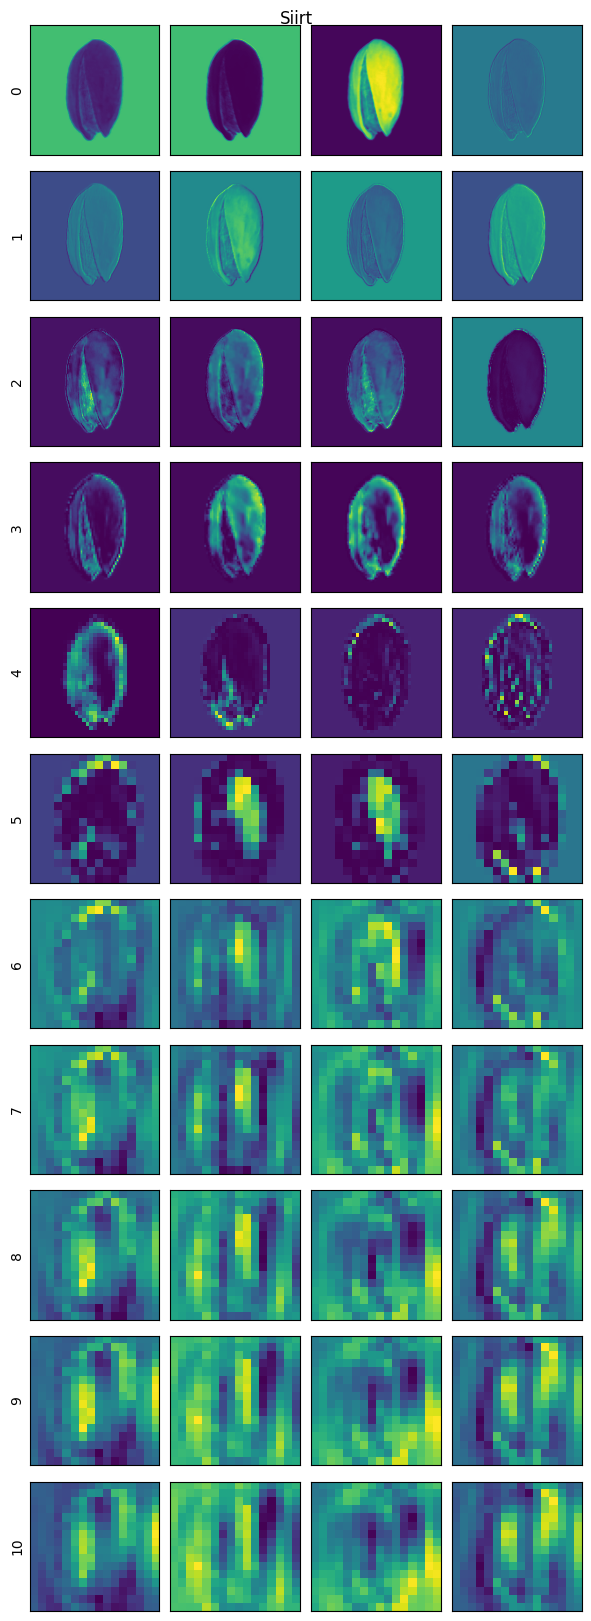

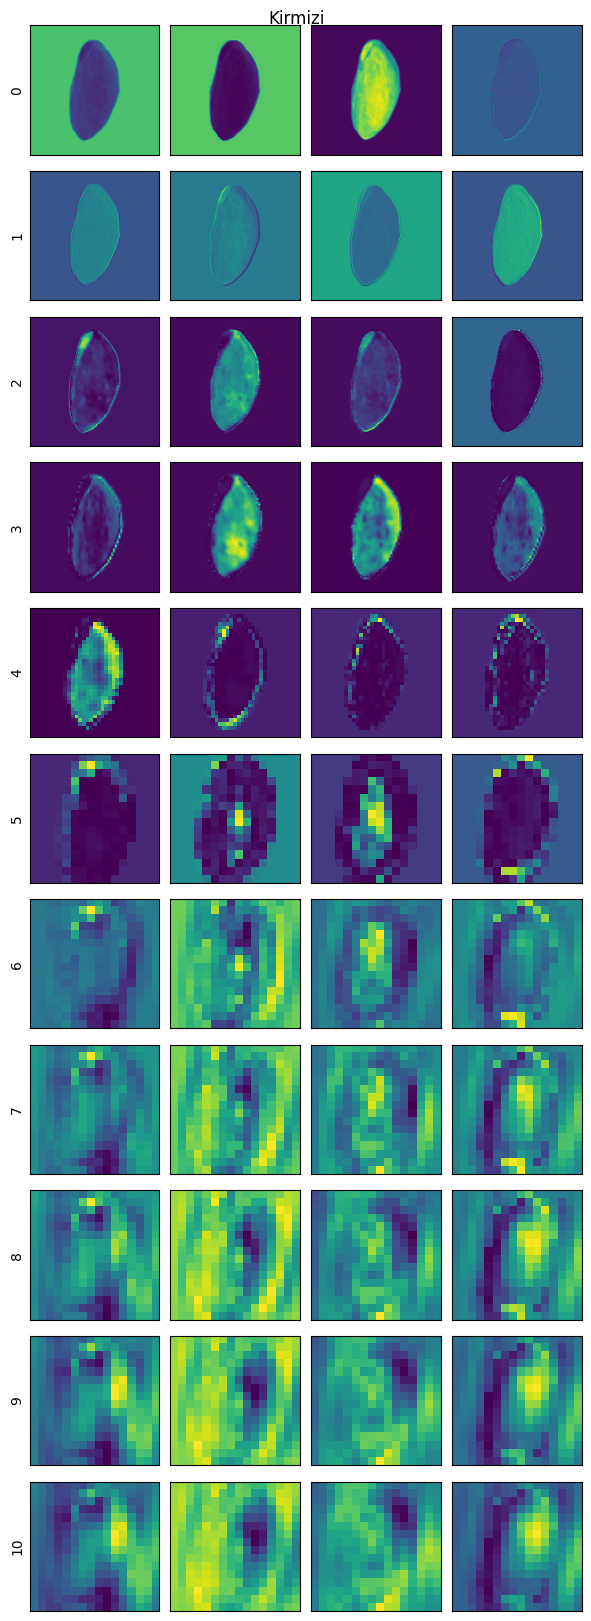

In [51]:
plot_features(TR.classifier.net, valid_data[0], [str(i) for i in range(11)], 4, s=1.5, title='Siirt')
plot_features(TR.classifier.net, valid_data[-1], [str(i) for i in range(11)], 4, s=1.5, title='Kirmizi')

While the model has many channels that could be plotted (up to 512), the examples are limited to four at a time for practicality.
The down-sampling layers (0-5) start by applying simple color filters to the base image, then build on previous layers to add different areas of focus like highlighting edges, the interior of the pistachio, and the outer shell. After reaching the residual block layers the rate of change between features seems to drastically reduce, and the feature sets become consistent (the same patterns in the same order). In the next step (not shown) all channels are concatenated together into a single channel via convolution at which point no recognisable features of the original pistachio remain.

### Conclusion
The goal of the project was to create neural-network based models capable of reliably categorizing images of different pistachio species (Siirt and Kirmizi). The chosen model was based on the same discriminator structure used in CycleGANs, which may be used for image categorization. After testing various hyperparameters a model with a F1-score of 0.98 on the validation data was trained, which made use of data augmentations that added random rotations and flips to the images. This model was closely followed by a smaller model without augmentations with an F1-score of 0.977, suggesting that the larger model was overfitting. Many additional hyperparameter combinations could be explored, but were determined to be beyond the scope of this project.

Exploring the best performing model revealed that a characteristic suggested by early data exploration may have been correct: Siirt pistachios appear to be wider, or rounder than the Kirmizi pistachios. Plotting the intermediate outputs of the model revealed the expected structure of the model, where deeper layers encode increasingly complex and refined features.

Future areas of exploration could include:
- Model ensembles
- Pre-trained vision models for feature encoding
- Additional hyperparameter combinations

All code for this project can be found on my [GitHub](github.com/nhansendev/DTSA_5511_FinalProject)

### References
Pistachio Image Dataset. (2022, March 28). Kaggle. https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset/data

junyanz/pytorch-CycleGAN-and-pix2pix: Image-to-Image Translation in PyTorch. (n.d.). 	https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/tree/master

BCEWithLogitsLoss — PyTorch 2.4 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

f1_score. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

Reproducibility — PyTorch 2.4 documentation. (n.d.). https://pytorch.org/docs/stable/notes/randomness.html